In [1]:
import gym

import habitat_sim
import magnum as mn
import warnings
from habitat.tasks.rearrange.rearrange_sim import RearrangeSim
warnings.filterwarnings('ignore')
from habitat_sim.utils.settings import make_cfg
from matplotlib import pyplot as plt
from habitat_sim.utils import viz_utils as vut
from omegaconf import DictConfig
import numpy as np
from habitat.articulated_agents.robots import FetchRobot
from habitat.config.default import get_agent_config
from habitat.config.default_structured_configs import ThirdRGBSensorConfig, HeadRGBSensorConfig, HeadPanopticSensorConfig
from habitat.config.default_structured_configs import SimulatorConfig, HabitatSimV0Config, AgentConfig
from habitat.config.default import get_agent_config
import habitat
from habitat_sim.physics import JointMotorSettings, MotionType
from omegaconf import OmegaConf

import git, os
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
os.chdir(dir_path)

/opt/anaconda3/envs/habitat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pybullet build time: May  1 2024 13:08:32


PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring


In [2]:

from habitat.config.default_structured_configs import TaskConfig, EnvironmentConfig, DatasetConfig, HabitatConfig
from habitat.config.default_structured_configs import ArmActionConfig, BaseVelocityActionConfig, OracleNavActionConfig, ActionConfig
from habitat.core.env import Env

def init_rearrange_sim(agent_dict):
    # Start the scene config
    sim_cfg = make_sim_cfg(agent_dict)    
    cfg = OmegaConf.create(sim_cfg)
    
    # Create the scene
    sim = RearrangeSim(cfg)

    # This is needed to initialize the agents
    sim.agents_mgr.on_new_scene()

    # For this tutorial, we will also add an extra camera that will be used for third person recording.
    camera_sensor_spec = habitat_sim.CameraSensorSpec()
    camera_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    camera_sensor_spec.uuid = "scene_camera_rgb"

    # TODO: this is a bit dirty but I think its nice as it shows how to modify a camera sensor...
    sim.add_sensor(camera_sensor_spec, 0)

    return sim

def make_sim_cfg(agent_dict):
    # Start the scene config
    sim_cfg = SimulatorConfig(type="RearrangeSim-v0")
    
    # Enable Horizon Based Ambient Occlusion (HBAO) to approximate shadows.
    sim_cfg.habitat_sim_v0.enable_hbao = True
    
    sim_cfg.habitat_sim_v0.enable_physics = True

    
    # Set up an example scene
    sim_cfg.scene = os.path.join(data_path, "hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json")
    sim_cfg.scene_dataset = os.path.join(data_path, "hab3_bench_assets/hab3-hssd/hab3-hssd.scene_dataset_config.json")
    sim_cfg.additional_object_paths = [os.path.join(data_path, 'objects/ycb/configs/')]

    
    cfg = OmegaConf.create(sim_cfg)

    # Set the scene agents
    cfg.agents = agent_dict
    cfg.agents_order = list(cfg.agents.keys())
    return cfg

def make_hab_cfg(agent_dict, action_dict):
    sim_cfg = make_sim_cfg(agent_dict)
    task_cfg = TaskConfig(type="RearrangeEmptyTask-v0")
    task_cfg.actions = action_dict
    env_cfg = EnvironmentConfig()
    dataset_cfg = DatasetConfig(type="RearrangeDataset-v0", data_path="data/hab3_bench_assets/episode_datasets/small_large.json.gz")
    
    
    hab_cfg = HabitatConfig()
    hab_cfg.environment = env_cfg
    hab_cfg.task = task_cfg
    hab_cfg.dataset = dataset_cfg
    hab_cfg.simulator = sim_cfg
    hab_cfg.simulator.seed = hab_cfg.seed

    return hab_cfg

def init_rearrange_env(agent_dict, action_dict):
    hab_cfg = make_hab_cfg(agent_dict, action_dict)
    res_cfg = OmegaConf.create(hab_cfg)
    return Env(res_cfg)

In [3]:
from habitat.tasks.rearrange.actions.articulated_agent_action import ArticulatedAgentAction
from habitat.core.registry import registry
from gym import spaces
import gzip
import json
from habitat.datasets.rearrange.rearrange_dataset import RearrangeEpisode
from habitat.datasets.rearrange.samplers.object_sampler import ObjectSampler

@registry.register_task_action
class PickObjIdAction(ArticulatedAgentAction):
    
    @property
    def action_space(self):
        MAX_OBJ_ID = 1000
        return spaces.Dict({
            f"{self._action_arg_prefix}pick_obj_id": spaces.Discrete(MAX_OBJ_ID)
        })

    def step(self, *args, **kwargs):
        obj_id = kwargs[f"{self._action_arg_prefix}pick_obj_id"]
        print(self.cur_grasp_mgr, obj_id)
        self.cur_grasp_mgr.snap_to_obj(obj_id)

In [4]:
class RearrangeEnv():
    def __init__(self) -> None:
        super().__init__()
        # Define the agent configuration
        main_agent_config = AgentConfig(is_set_start_state=True)
        urdf_path = os.path.join(data_path, "robots/hab_fetch/robots/hab_fetch.urdf")
        main_agent_config.articulated_agent_urdf = urdf_path
        main_agent_config.articulated_agent_type = "FetchRobot"

        # Define sensors that will be attached to this agent, here a third_rgb sensor and a head_rgb.
        # We will later talk about why we are giving the sensors these names
        main_agent_config.sim_sensors = {
            "third_rgb": ThirdRGBSensorConfig(),
            "head_rgb": HeadRGBSensorConfig(),
        }

        # We create a dictionary with names of agents and their corresponding agent configuration
        agent_dict = {"main_agent": main_agent_config}

        action_dict = {
            "pick_obj_id_action": ActionConfig(type="PickObjIdAction"),
            "base_velocity_action": BaseVelocityActionConfig(),
            "oracle_coord_action": OracleNavActionConfig(type="OracleNavCoordinateAction", spawn_max_dist_to_obj=1.0)
        }
        self.env = init_rearrange_env(agent_dict, action_dict)
        
        camera_sensor_spec = habitat_sim.CameraSensorSpec()
        camera_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
        camera_sensor_spec.uuid = "scene_camera_rgb"

        # TODO: this is a bit dirty but I think its nice as it shows how to modify a camera sensor...
        self.env.sim.add_sensor(camera_sensor_spec, 0)
        # main_agent_config = AgentConfig()
        # urdf_path = os.path.join(data_path, "robots/hab_fetch/robots/hab_fetch.urdf")
        # main_agent_config.articulated_agent_urdf = urdf_path
        # main_agent_config.articulated_agent_type = "FetchRobot"

        # # Define sensors that will be attached to this agent, here a third_rgb sensor and a head_rgb.
        # # We will later talk about why we are giving the sensors these names
        # main_agent_config.sim_sensors = {
        #     "third_rgb": ThirdRGBSensorConfig(),
        #     "head_rgb": HeadRGBSensorConfig(),
        # }

        # # We create a dictionary with names of agents and their corresponding agent configuration
        # agent_dict = {"main_agent": main_agent_config}
        # self.sim = init_rearrange_sim(agent_dict)
        
        # self.num_goals = 5
        
        # fps = 60 # Default value for make video
        # self.dt = 1./fps
        
        # self.goal_location = mn.Vector(-7.16318, 0.85088, -3.13086)
        episode_file = os.path.join(data_path, "hab3_bench_assets/episode_datasets/small_large.json.gz")
        # Load the dataset
        with gzip.open(episode_file, "rt") as f: 
            episode_files = json.loads(f.read())

        # Get the first episode
        episode = episode_files["episodes"][0]
        self.rearrange_episode = RearrangeEpisode(**episode)
    
    def reset(self):
        self.env.reset()
        
        sim = self.env.sim
        art_agent = sim.articulated_agent
        art_agent._fixed_base = True
        sim.agents_mgr.on_new_scene()

        sim.reconfigure(sim.habitat_config, ep_info=self.rearrange_episode)
        
        art_agent = self.env.sim.articulated_agent
        init_pos = mn.Vector3(-5.5,0,-1.5)
        # Define the agent configuration
        sim = self.env.sim
        sim.reset()
        art_agent.sim_obj.motion_type = MotionType.KINEMATIC
        sim.articulated_agent.base_pos =  init_pos 
        _ = sim.step({})

        # art_agent._fixed_base = False
        # self.sim.agents_mgr.on_new_scene()
        # # The base is not fixed anymore
        # art_agent.sim_obj.motion_type = MotionType.DYNAMIC
        # art_agent.base_pos = init_pos + mn.Vector3(0,1.5,0)
        # _ = self.sim.step({})
        # observations = self.sim.get_sensor_observations()
        # # return observations
        # self.frames = []
    
    def _step(self, action_dict):
        obs = self.env.step(action_dict)
        done = self.env.episode_over
        return obs, done
    
    def navigate_to_pos(self, object_trans):
        observations = []
        done = False
        object_agent_vec = self.env.sim.articulated_agent.base_pos - object_trans
        object_agent_vec.y = 0
        dist_agent_object = object_agent_vec.length()
        # Walk towards the object

        agent_displ = np.inf
        agent_rot = np.inf
        prev_rot = self.env.sim.articulated_agent.base_rot
        prev_pos = self.env.sim.articulated_agent.base_pos
        while agent_displ > 1e-9 or agent_rot > 1e-9:
            prev_rot = self.env.sim.articulated_agent.base_rot
            prev_pos = self.env.sim.articulated_agent.base_pos
            action_dict = {
                "action": ("oracle_coord_action"), 
                "action_args": {
                    "oracle_nav_lookat_action": object_trans,
                    "mode": 1
                }
            }
            obs, done = self._step(action_dict)
            observations.append(obs)
            if done:
                break
            cur_rot = self.env.sim.articulated_agent.base_rot
            cur_pos = self.env.sim.articulated_agent.base_pos
            agent_displ = (cur_pos - prev_pos).length()
            agent_rot = np.abs(cur_rot - prev_rot)

        # Wait
        # for _ in range(20):
        #     if done:
        #         break
        #     action_dict = {"action": (), "action_args": {}}
        #     obs, done = self.env.step()
        #     observations.append(self.env.step(action_dict))
        return observations, done
            
    def pick_object(self, object_id):
        rom = self.env.sim.get_rigid_object_manager()
        first_object = rom.get_object_by_id(object_id)

        object_trans = first_object.translation
        print(first_object.handle, "is in", object_trans)

        # print(sample)
        observations, done = self.navigate_to_pos(object_trans)
        # delta = 2.0
        if done:
            return observations, "cannot navigate to object"

        action_dict = {"action": ("pick_obj_id_action"), "action_args": {"pick_obj_id": object_id}}
        obs, done = self._step(action_dict)
        observations.append(obs)
        
        if done:
            return observations, "failed to pick object"
        # for _ in range(10):
        #     action_dict = {"action": (), "action_args": {}}
        #     observations.append(self.env.step(action_dict))
            
        return observations, "picked object"

    def place_object(self, goal):
        # rom = self.env.sim.get_rigid_object_manager()
        # first_object = rom.get_object_by_id(goal_id)

        # object_trans = first_object.translation
        observations, done = self.navigate_to_pos(goal)
        if done:
            return observations, "cannot navigate to goal"
        
        agent_id = 0
        grasp_manager = self.env.sim.agents_mgr[agent_id].grasp_mgrs[0]
        grasp_manager.desnap()
        for _ in range(10):
            action_dict = {"action": (), "action_args": {}}
            obs, done = self._step(action_dict)
            observations.append(obs)
            if done:
                return observations, "cannot place object"
        return observations, "placed object successfull"
        
    def step(self, obj_index):
        object_maps = [
            # "003_cracker_box_:0000",
            # "008_pudding_box_:0000",
            # "009_gelatin_box_:0000",
            # "008_pudding_box_:0001",
            # "007_tuna_fish_can_:0000",
            # "007_tuna_fish_can_:0001",
            # "003_cracker_box_:0001",
            # "007_tuna_fish_can_:0002",
            # "005_tomato_soup_can_:0000"
            "004_sugar_box_:0000",
            "009_gelatin_box_:0000",
            "010_potted_meat_can_:0000",
            # "024_bowl_:0000",
            "007_tuna_fish_can_:0000",
            "002_master_chef_can_:0000",
        ]
        
        # object_maps = [
        #     (111, "003_cracker_box_"),
        #     (113, "004_sugar_box_"),
        #     (117, "009_gelatin_box_"),
        #     (118, "010_potted_meat_can_"),
        #     (114, "007_tuna_fish_can_"),
        #     (109, "002_master_chef_can_"),
        # ]
        rom = self.env.sim.get_rigid_object_manager()
        obj_id = rom.get_object_id_by_handle(object_maps[obj_index])
        
        first_object = rom.get_object_by_id(obj_id)
        print(f"chosen: {object_maps[obj_index]}, selected: {first_object.handle}")
        goal = mn.Vector3(-7.29429, 0.894202, -7.25061)#mn.Vector3(-7.16318, 0.85088, -3.13086)
        # {}, {-6.25845, 0.898544, -5.20799}
        # Vector(-7.07397, 0.180179, -6.73884)
        # goal_obj_id = rom.get_object_id_by_handle("024_bowl_:0000")
        observations, state1 = self.pick_object(obj_id)
        print(state1)
        observations2, state2 = self.place_object(goal)
        observations.extend(observations2)
        print(state2)
        return observations, object_maps[obj_index]
        

In [5]:
def print_env(env):
    sim = env.env.sim
    # aom = sim.get_articulated_object_manager()
    rom = sim.get_rigid_object_manager()

    # We can query the articulated and rigid objects

    # print("List of articulated objects:")
    # for handle, ao in aom.get_objects_by_handle_substring().items():
    #     print(handle, "id", aom.get_object_id_by_handle(handle))

    print("\nList of rigid objects:")
    obj_ids = []
    for handle, ro in rom.get_objects_by_handle_substring().items():
        if ro.awake:
            print(handle, "id", ro.object_id)
            obj_ids.append(ro.object_id)
    print("=="*10)

In [6]:
env = RearrangeEnv()

for obj_id in range(1):
    env.reset()
    print_env(env)
    observations, obj_name = env.step(obj_id)
    vut.make_video(
        observations,
        "head_rgb",
        "color",
        f"videos/{obj_name}",
        open_vid=False,
    )

2024-05-13 18:40:46,532 Initializing dataset RearrangeDataset-v0
2024-05-13 18:40:46,535 initializing sim RearrangeSim-v0
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
[18:46:43:385711]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes 'data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[18:46:43:385795]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: File../hssd-

Renderer: Apple M2 Pro by Apple
OpenGL version: 4.1 Metal - 86
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


GL::AbstractShaderProgram::link(): linking succeeded with the following message:
GL::AbstractShaderProgram::link(): linking succeeded with the following message:
GL::AbstractShaderProgram::link(): linking succeeded with the following message:
GL::AbstractShaderProgram::link(): linking succeeded with the following message:
GL::AbstractShaderProgram::link(): linking succeeded with the following message:
GL::AbstractShaderProgram::link(): linking succeeded with the following message:
GL::AbstractShaderProgram::link(): linking succeeded with the following message:



List of rigid objects:
024_bowl_:0000 id 109
010_potted_meat_can_:0000 id 110
009_gelatin_box_:0000 id 111
004_sugar_box_:0000 id 113
007_tuna_fish_can_:0000 id 112
002_master_chef_can_:0000 id 118
002_master_chef_can_:0003 id 115
002_master_chef_can_:0002 id 116
002_master_chef_can_:0001 id 117
002_master_chef_can_:0004 id 114
chosen: 004_sugar_box_:0000, selected: 004_sugar_box_:0000
004_sugar_box_:0000 is in Vector(-7.09642, 0.548565, 1.31539)
<habitat.tasks.rearrange.rearrange_grasp_manager.RearrangeGraspManager object at 0x2af53d190> 113
picked object
placed object successfull
Encoding the video: videos/004_sugar_box_:0000.mp4 


In [8]:
observations[0].keys()

dict_keys(['third_rgb', 'head_rgb'])

In [7]:
import os
from typing import TYPE_CHECKING, Union, cast

import git
import matplotlib.pyplot as plt
import numpy as np

import habitat
from habitat.config.default_structured_configs import (
    CollisionsMeasurementConfig,
    FogOfWarConfig,
    TopDownMapMeasurementConfig,
)
from habitat.core.agent import Agent
from habitat.tasks.nav.nav import NavigationEpisode, NavigationGoal
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from habitat.utils.visualizations import maps
from habitat.utils.visualizations.utils import (
    images_to_video,
    observations_to_image,
    overlay_frame,
)
# Quiet the Habitat simulator logging
os.environ["MAGNUM_LOG"] = "quiet"
os.environ["HABITAT_SIM_LOG"] = "quiet"

def example_get_topdown_map(env):
    top_down_map = maps.get_topdown_map_from_sim(
            env.env.sim, map_resolution=1024
    )
    recolor_map = np.array(
        [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
    )
        # By default, `get_topdown_map_from_sim` returns image
        # containing 0 if occupied, 1 if unoccupied, and 2 if border
        # The line below recolors returned image so that
        # occupied regions are colored in [255, 255, 255],
        # unoccupied in [128, 128, 128] and border is [0, 0, 0]
    top_down_map = recolor_map[top_down_map]
    plt.imshow(top_down_map)
    plt.title("top_down_map.png")
    plt.show()

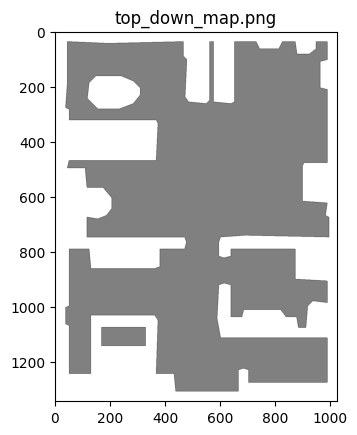

In [8]:
example_get_topdown_map(env)

In [ ]:
def example_top_down_map_measure():
    # Create habitat config
    config = habitat.get_config(
        config_path=os.path.join(
            dir_path,
            "habitat-lab/habitat/config/benchmark/nav/pointnav/pointnav_habitat_test.yaml",
        )
    )
    # Add habitat.tasks.nav.nav.TopDownMap and habitat.tasks.nav.nav.Collisions measures
    with habitat.config.read_write(config):
        config.habitat.task.measurements.update(
            {
                "top_down_map": TopDownMapMeasurementConfig(
                    map_padding=3,
                    map_resolution=1024,
                    draw_source=True,
                    draw_border=True,
                    draw_shortest_path=True,
                    draw_view_points=True,
                    draw_goal_positions=True,
                    draw_goal_aabbs=True,
                    fog_of_war=FogOfWarConfig(
                        draw=True,
                        visibility_dist=5.0,
                        fov=90,
                    ),
                ),
                "collisions": CollisionsMeasurementConfig(),
            }
        )
    # Create dataset
    dataset = habitat.make_dataset(
        id_dataset=config.habitat.dataset.type, config=config.habitat.dataset
    )
    # Create simulation environment
    with habitat.Env(config=config, dataset=dataset) as env:
        # Create ShortestPathFollowerAgent agent
        agent = ShortestPathFollowerAgent(
            env=env,
            goal_radius=config.habitat.task.measurements.success.success_distance,
        )
        # Create video of agent navigating in the first episode
        num_episodes = 1
        for _ in range(num_episodes):
            # Load the first episode and reset agent
            observations = env.reset()
            agent.reset()

            # Get metrics
            info = env.get_metrics()
            # Concatenate RGB-D observation and topdowm map into one image
            frame = observations_to_image(observations, info)

            # Remove top_down_map from metrics
            info.pop("top_down_map")
            # Overlay numeric metrics onto frame
            frame = overlay_frame(frame, info)
            # Add fame to vis_frames
            vis_frames = [frame]

            # Repeat the steps above while agent doesn't reach the goal
            while not env.episode_over:
                # Get the next best action
                action = agent.act(observations)
                if action is None:
                    break

                # Step in the environment
                observations = env.step(action)
                info = env.get_metrics()
                frame = observations_to_image(observations, info)

                info.pop("top_down_map")
                frame = overlay_frame(frame, info)
                vis_frames.append(frame)

            current_episode = env.current_episode
            video_name = f"{os.path.basename(current_episode.scene_id)}_{current_episode.episode_id}"
            # Create video from images and save to disk
            images_to_video(
                vis_frames, output_path, video_name, fps=6, quality=9
            )
            vis_frames.clear()
            # Display video
            vut.display_video(f"{output_path}/{video_name}.mp4")